Juypter notebook focusing on the investigation and use of the MS COCO dataset. This was created for CSU's CS445

The goal of this model is to recognize and select specific things out of a photo

With that in mind we will be developing it specifically for instance segmentation.

However due to compute requirements the training of this model was done specifically to select a dog out of any photo. Given more compute, this same pipeline could be used with more classes added to the target categories

Contributers: Tucker Laurence, Yasas Wijesekara

In [46]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import urllib
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from collections import Counter
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random


Global variables used to select conditions about the dataset


In [47]:
random.seed(42)
annotation_dir='./../annotations'
val_data_name='val2017'
train_data_name='train2017'

val_image_dir = './../datasets/val'
train_image_dir = './../datasets/train'

#ORDER IS IMPORTANT IF REUSING A TRAINED MODEL
#class labels are defined by index
#so if you have a ['dog'] trained model it will think dogs are class 1
#if you want to train it on a new class it needs to be in the same order
# IE adding cats has to be ['dog','cat']
# Because ['cat','dog'] will use the wrong class labels (model will think cats are dogs and dogs are a new class)
# relevant_categories = ['cat', 'dog', 'cow', 'horse', 'bird']
initial_categories = ['dog']

The custom dataset used to load in and manipulate the data into a trainable format


In [48]:
class CocoSegmentationDataset(Dataset):
    """
    PyTorch Dataset for COCO-style instance segmentation tasks.
    if attribute normalize is set to True then any index retrieved sample is normalized

     Args:
        img_dir (str): Path to directory containing images.
        annotation_directory (str): Path to directory with COCO annotation JSON file.
        data_name (str): Name suffix for COCO annotation file.
        relevant_categories (List[str]): List of category names to include.
        transforms (callable, optional): Transformation function to apply to images and targets.
        """
    
    def __init__(self, img_dir, annotation_directory, data_name, relevant_categories, loaded_categories=None, verbose=False, transforms=None, samples=None):
        self.verbose = verbose
        self.samples = samples
        
        # Initialize COCO API and get data during instantiation
        annFile = '{}/instances_{}.json'.format(annotation_directory, data_name)
        self.coco = COCO(annFile)
        
        #information about the images
        self.img_dir = img_dir #where it stored
        self.relevant_categories = relevant_categories #what categories we want to train for
        self.loaded_categories = loaded_categories
        
        category_ids, image_ids = self._instantiate_ids() #get the id tags for each piece of information
        # print(type(category_ids))
        # print(type(image_ids))
        # print(category_ids)
        # print(image_ids)
        
        self.image_ids = image_ids
        self.category_ids = category_ids
        
        # Map category_ids to new 1-X labels dynamically
        self.category_to_class_dict = {cat_id: idx+1 for idx, cat_id in enumerate(self.category_ids)}
        self.class_to_category_dict = {v: k for k, v in self.category_to_class_dict.items()}
        
        # print(category_ids)
        # print(self.category_to_class_dict)
        # print(self.class_to_category_dict)
        
        #Transforms and normalizations
        self.enable_resize = False
        self.transforms = transforms
        self.image_resize_dimensions = (224,224)
        
    def _get_ordered_category_ids(self, categories):
        category_ids = []
        for single_category in categories:
            single_id = self.coco.getCatIds(catNms=single_category)
            category_ids += single_id
        
        return category_ids
            
    def _instantiate_ids(self):
        #Use coco to retrieve the category ids for target classes
        category_ids = self._get_ordered_category_ids(self.relevant_categories)
        loaded_category_ids = category_ids #set the categories we will be loading to all relevant ones
        
        if self.loaded_categories != None: #if we are only loading a specific classes training info
            loaded_category_ids = self._get_ordered_category_ids(self.loaded_categories)
        
        image_ids = []
        
        #loop through category ids get all images with those contained
        for category in loaded_category_ids:
            temp_img_ids = self.coco.getImgIds(catIds=category)
            image_ids += temp_img_ids
        
        image_ids = list(set(image_ids)) #turn into list
        
        if self.loaded_categories != None:
            print(f"Restricted to {len(image_ids)} images for only {self.loaded_categories} out of {self.relevant_categories}")
        else :
            print(f"Found {len(image_ids)} images for {self.relevant_categories}")
        
        #Restrict to a set size
        if self.samples != None: #we are limiting samples
            if len(image_ids) >= self.samples: #if the image ids is more than the number of samples we want
                image_ids = random.sample(image_ids, self.samples) #randomly sample 'sample' number of ids
                print(f'Restricted to {len(image_ids)} samples')
        
        return category_ids, image_ids #return the category and image ids

    def __len__(self):
        """
        Returns:
            int: Number of image samples.
        """
        return len(self.image_ids)

    def __getitem__(self, index):
        """
        Loads a sample image and its corresponding target annotation.

        Args:
            index (int): Index of the sample to load.

        Returns:
            Tuple[Image.Image, Dict]: The image and a dictionary containing 'boxes', 'labels', 'masks', and 'image_id'.
        """
        if self.verbose:
            print(f"Loading item {index}")
            
        img_id = self.image_ids[index] #get the image id for a specific index
        img_info = self.coco.loadImgs(img_id)[0] #load intos information
        img_path = os.path.join(self.img_dir, img_info['file_name']) #get its local path
        image = Image.open(img_path).convert("RGB") #load the image

        #get its annotation information
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        #instantiate target lists
        masks = []
        boxes = []
        labels = []

        #loop through all annotations in the image
        for ann in anns:
            #get mask information of an annotation
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            #get box information of an annotation
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

            #get label information, but remap to its target class, rather than category
            original_label = ann['category_id'] #get json label            
            labels.append(self.category_to_class_dict[original_label])  # remapped label using dictionary so that labels contains 1-x classes

        #cast to expected tensor types
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        #build the target information dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id]),
        }

        #if normalizing resize image, box, and mask
        if self.enable_resize:
            image, target = self._normalize_sample(image, target, new_size=self.image_resize_dimensions)
        
        #perform any transforms
        if self.transforms:
            image, target = self.transforms(image, target)
        else: #if no transforms always turn it into a tensor
            image = transforms.ToTensor()(image)

        return image, target
    
    def _normalize_sample(self, image, target, new_size):
        """
        Resizes image, bounding boxes, and masks to a given size.

        Args:
            image (PIL.Image or torch.Tensor): The image to normalize.
            target (dict): Dictionary containing 'boxes' and 'masks'.
            new_size (Tuple[int, int]): Desired (width, height) for output image and masks.

        Returns:
            Tuple[PIL.Image.Image, Dict]: Resized image and updated target dictionary.
        """
        new_w, new_h = new_size

        if isinstance(image, torch.Tensor):
            old_h, old_w = image.shape[-2], image.shape[-1]
            image = F.to_pil_image(image)
        else:
            old_w, old_h = image.size

        # Resize image
        image = image.resize((new_w, new_h))

        # Scale boxes
        scale_x = new_w / old_w
        scale_y = new_h / old_h
        boxes = target['boxes']
        boxes = boxes.clone()
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_x
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_y
        target['boxes'] = boxes

        # Resize masks
        resized_masks = []
        for mask in target['masks']:
            mask_img = Image.fromarray(mask.numpy())
            resized_mask = mask_img.resize((new_w, new_h), resample=Image.NEAREST)
            resized_masks.append(np.array(resized_mask))
        target['masks'] = torch.as_tensor(np.stack(resized_masks), dtype=torch.uint8)

        return image, target
    
    def filter_valid_images(self):
        valid_image_ids = []
        for img_id in self.image_ids:
            try:
                img_info = self.coco.loadImgs(img_id)[0]
                img_path = os.path.join(self.img_dir, img_info['file_name'])
                image = Image.open(img_path).convert("RGB")
                ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                
                # Validate there is at least one valid annotation
                if len(anns) == 0:
                    continue

                # Check for valid masks and bounding boxes
                for ann in anns:
                    _ = self.coco.annToMask(ann)
                    _ = ann['bbox']
                
                valid_image_ids.append(img_id)

            except Exception as e:
                if self.verbose:
                    print(f"Skipping image {img_id} due to error: {e}")
                continue

        print(f"Filtered dataset down to {len(valid_image_ids)} valid images.")
        
        self.image_ids = valid_image_ids
    
    def download_images(self, verbose=False):
        """
        Downloads COCO images into the specified image directory if they are not already present.

        Args:
            verbose (bool, optional): Whether to print progress messages. Defaults to False.
        """
        current_image_count = 1
        total_image_count = len(self)

        if not os.path.exists(self.img_dir):
            os.makedirs(self.img_dir)

        for img_id in self.image_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            file_name = img_info['file_name']
            url = img_info.get('coco_url')

            img_count_string = f'{current_image_count}/{total_image_count}'

            if url is None:
                print(f"No URL found for image {file_name}, skipping.")
                continue

            save_path = os.path.join(self.img_dir, file_name)
            if not os.path.exists(save_path):
                try:
                    urllib.request.urlretrieve(url, save_path)
                    if verbose: print(f"{img_count_string} Downloaded {file_name}")
                except Exception as e:
                    if verbose:  print(f"{img_count_string} Failed to download {file_name}: {e}")
            else:
                if verbose: print(f"{img_count_string} Image already exists: {file_name}")

            current_image_count += 1

        print(f'Interfaced with {current_image_count-1} unique images')
    
    def create_class_to_label_dict(self):
        """
        Creates a dictionary where the class index maps to its corresponding category label.
        """
        class_to_label_dict = {}

        for index, category_id in self.class_to_category_dict.items():
            # Fetch the category name using the category ID
            category_name = self.coco.loadCats([category_id])[0]['name']
            class_to_label_dict[index] = category_name

        return class_to_label_dict

    def show_data_distribution(self):
        """
        Displays a bar chart of the number of instances per category in the dataset.
        """
        all_labels = []
        category_labels = []
        
        for index in range(len(self)):
            _, target = self.__getitem__(index)
            all_labels.extend(target['labels'].tolist())
        
        for label in all_labels:
            category_labels.append(self.class_to_category_dict[label])

        label_counts = Counter(category_labels)
        category_names = [self.coco.loadCats([cat_id])[0]['name'] for cat_id in label_counts.keys()]
        counts = list(label_counts.values())

        plt.figure(figsize=(10, 5))
        plt.bar(category_names, counts, color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Number of Instances')
        plt.title('Category Distribution in Dataset')
        plt.tight_layout()
        plt.show()

Extended data class to train against FP by introducing negative instances

In [49]:
class NegativeCoCoSegmentationDataset(CocoSegmentationDataset):
    def __init__(self, img_dir, annotation_directory, data_name, relevant_categories, negative_categories, verbose=False, transforms=None):
        super().__init__(img_dir, annotation_directory, data_name, negative_categories, verbose, transforms)
        #we now have the standard dataset, but for the negative categories
        
        self.positive_categories = relevant_categories
        self.negative_categores = negative_categories
        self.positive_category_ids = self.coco.getCatIds(catNms=self.positive_categories)
        
        self.category_to_class_dict = {cat_id: idx+1 for idx, cat_id in enumerate(self.positive_category_ids)}
        
    def __getitem__(self, index):
        """
        Loads a sample image and its corresponding target annotation. 
        EXCLUDES target annotations for anything other than positive samples

        Args:
            index (int): Index of the sample to load.

        Returns:
            Tuple[Image.Image, Dict]: The image and a dictionary containing 'boxes', 'labels', 'masks', and 'image_id'.
        """
        if self.verbose:
            print(f"Loading item {index}")
            
        img_id = self.image_ids[index] #get the image id for a specific index
        img_info = self.coco.loadImgs(img_id)[0] #load intos information
        img_path = os.path.join(self.img_dir, img_info['file_name']) #get its local path
        image = Image.open(img_path).convert("RGB") #load the image

        #get its annotation information
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.positive_category_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        #instantiate target lists
        masks = []
        boxes = []
        labels = []

        #loop through all annotations in the image
        for ann in anns:
            #get mask information of an annotation
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            #get box information of an annotation
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

            #get label information, but remap to its target class, rather than category
            original_label = ann['category_id'] #get json label            
            labels.append(self.category_to_class_dict[original_label])  # remapped label using dictionary so that labels contains 1-x classes

        #cast to expected tensor types
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        #build the target information dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id]),
        }

        #if normalizing resize image, box, and mask
        if self.enable_resize:
            image, target = self._normalize_sample(image, target, new_size=self.image_resize_dimensions)
        
        #perform any transforms
        if self.transforms:
            image, target = self.transforms(image, target)
        else: #if no transforms always turn it into a tensor
            image = transforms.ToTensor()(image)

        return image, target

Visualizer to show image and its labeling

In [50]:
def visualize(images: list, targets: list, label_map: dict, enable_box=False, enable_mask=False, enable_label=True):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    max_cols = 4
    num_images = len(images)
    num_rows = (num_images + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(max_cols * 4, num_rows * 4), facecolor='black')
    gs = gridspec.GridSpec(num_rows, max_cols, figure=fig, wspace=0.05, hspace=0.05)

    for idx in range(num_images):
        row = idx // max_cols
        col = idx % max_cols
        ax = fig.add_subplot(gs[row, col])
        ax.set_axis_off()

        image = images[idx]
        target = targets[idx]

        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)
        ax.imshow(image)

        if enable_box:
            boxes = target['boxes']
            for box in boxes:
                xmin, ymin, xmax, ymax = box.tolist()
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        if enable_mask:
            masks = target['masks']
            for mask in masks:
                mask = mask.squeeze()
                if mask.ndimension() == 1:
                    mask = mask.view(int(mask.size(0) ** 0.5), -1)
                if mask.ndim == 3:
                    mask = mask.squeeze()
                mask = mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask
                rgba_mask = np.zeros((*mask.shape, 4), dtype=np.float32)
                rgba_mask[..., 0] = 1.0
                rgba_mask[..., 3] = mask * 0.5
                ax.imshow(rgba_mask)

        if enable_label:
            labels = target['labels']
            boxes = target['boxes']
            for label_id, box in zip(labels, boxes):
                label_text = label_map.get(label_id.item(), str(label_id.item()))
                xmin, ymin, xmax, ymax = box.tolist()
                cx = (xmin + xmax) / 2
                cy = (ymin + ymax) / 2
                ax.text(cx, cy, label_text, color='white', fontsize=12, ha='center', va='center')
                
    plt.show()


In [51]:
val_dataset = CocoSegmentationDataset(val_image_dir, annotation_dir, val_data_name, initial_categories)
val_dataset.download_images(verbose=False)
val_dataset.filter_valid_images()
label_map = val_dataset.create_class_to_label_dict()

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Found 177 images for ['dog']
Interfaced with 177 unique images
Filtered dataset down to 176 valid images.


Show the first n images of the dataset

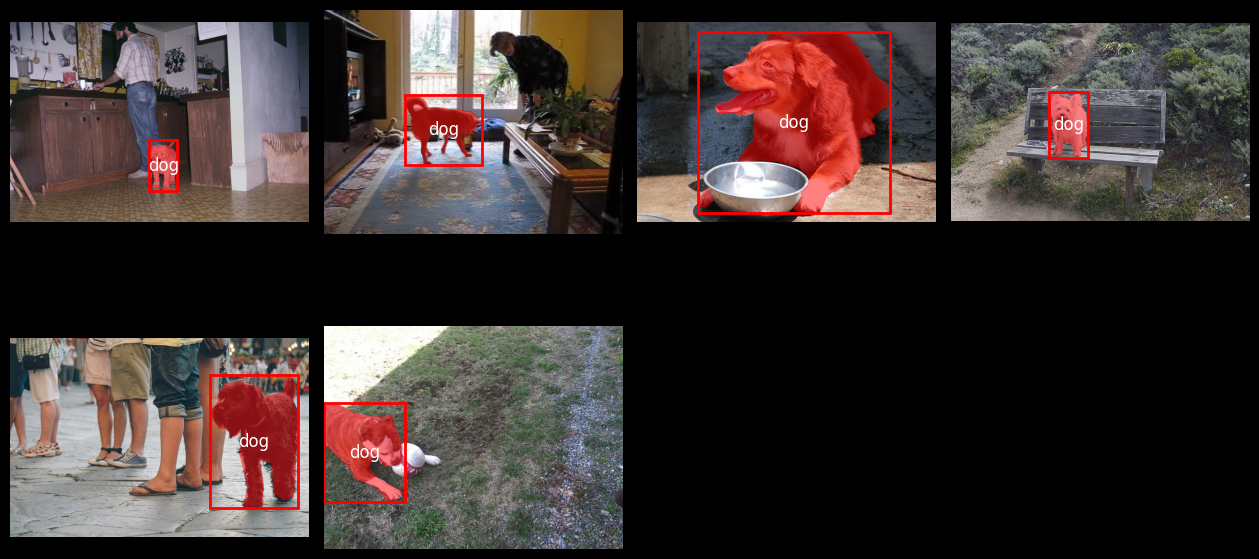

In [52]:
n_images = 6
images = []
targets = []
for i in range(n_images):
    image, target = val_dataset[i]
    images.append(image)
    targets.append(target)
visualize(images, targets, label_map, enable_box=True, enable_mask=True, enable_label=True)


In [53]:
#Example of how to add negative images to the dataset

# negative_categories = ['cat']
# negative_cat_dataset = NegativeCoCoSegmentationDataset(val_image_dir, annotation_dir, val_data_name, initial, negative_categories)
# negative_cat_dataset.download_images(verbose=False)
# negative_cat_dataset.filter_valid_images()

# n_images = 6
# images = []
# targets = []
# for i in range(n_images):
#     image, target = negative_cat_dataset[i]
#     images.append(image)
#     targets.append(target)

# visualize(images, targets, label_map, enable_box=True, enable_mask=True, enable_label=True)

mask RCNN model testing

In [54]:
#How the data is formatted in a batch
def custom_collate(batch):
    return tuple(zip(*batch))

In [55]:
def get_instance_segmentation_model(categories):
    num_classes = len(categories) + 1  # +1 for background
    
    # Load a model pre-trained on COCO
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)

    # Replace the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )
    
    return model

Create initial training loop

In [56]:
def train_maskrcnn(model, data_loader, extra_info=""):
    # Training setup
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Construct optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    num_epochs = 10

    print("Starting Training")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        print(f"Epoch: {epoch+1}")
        for images, targets in tqdm(data_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()

        lr_scheduler.step()
        
        torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': lr_scheduler.state_dict(),
        'loss_history': running_loss,
    }, f'./../masrk_rcnn_epoch_{epoch+1}_{extra_info}.pth')

        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")
        
    return model

In [57]:
def evaluate_maskrcnn_with_image(model, image_directory, threshold=0.5):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    image = Image.open(image_directory).convert("RGB")

    transform = T.Compose([
        T.ToTensor(),  # Convert to tensor and scale [0, 255] -> [0.0, 1.0]
    ])
    image_tensor = transform(image).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor])

    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu()
    pred_boxes = prediction[0]['boxes'].cpu().numpy()

    # Filter predictions by threshold
    keep = pred_scores >= threshold

    filtered_predictions = {
        'scores': pred_scores[keep],
        'labels': pred_labels[keep],
        'masks': pred_masks[keep],
        'boxes': pred_boxes[keep],
    }

    return image_tensor, filtered_predictions

In [58]:
val_dataset.verbose = False
val_dataset.enable_resize = True #

train_loader = DataLoader(val_dataset, 
            batch_size=8, 
            shuffle=True,
            num_workers=0, 
            collate_fn=custom_collate
            )

#ONLY TURN ON IF YOU WANT TO TRAIN A NEW MaskRCNN MODEL
# new_model = get_instance_segmentation_model(initial_categories)
# new_model = train_maskrcnn(new_model, train_loader)

Load the model

In [59]:
loaded_model = get_instance_segmentation_model(categories=initial_categories)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loaded_model.to(device)
checkpoint = torch.load('./../models/checkpoint.pth', map_location=device)
loaded_model.load_state_dict(checkpoint['model_state'])


<All keys matched successfully>

initial display on custom images

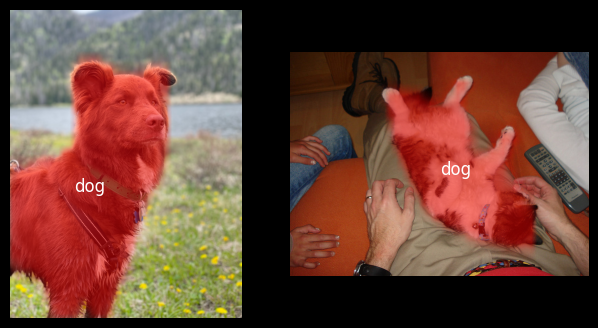

In [60]:
new_dog_image = './../theo.jpg' #Local image of a friends dog
new_cat_image = './../datasets/train/000000000443.jpg' #image from the train set of a cat
test_image_tensors_list = []
test_image_predictions_list = []

test_image_tensor, test_image_prediction = evaluate_maskrcnn_with_image(loaded_model, new_dog_image, threshold=0.8)
test_image_tensors_list.append(test_image_tensor)
test_image_predictions_list.append(test_image_prediction)

test_image_tensor, test_image_prediction = evaluate_maskrcnn_with_image(loaded_model, new_cat_image, threshold=0.8)
test_image_tensors_list.append(test_image_tensor)
test_image_predictions_list.append(test_image_prediction)


visualize(test_image_tensors_list, test_image_predictions_list, label_map, enable_mask=True)

Predicts dogs well, but has large FP for cats, lets train in cats as its own unique class

In [61]:
new_categories = ['dog', 'cat']
new_loaded_category = ['cat']
new_cat_train_dataset = CocoSegmentationDataset(val_image_dir, annotation_dir, val_data_name, new_categories, new_loaded_category, samples=80)
new_cat_train_dataset.verbose = False
new_cat_train_dataset.enable_resize = True

cat_data_loader = DataLoader(new_cat_train_dataset, 
            batch_size=8, 
            shuffle=True,
            num_workers=0, 
            collate_fn=custom_collate
            )

cat_model = get_instance_segmentation_model(categories=new_categories)
cat_model = train_maskrcnn(cat_model, cat_data_loader, "CatClassTraining")

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Restricted to 184 images for only ['cat'] out of ['dog', 'cat']
Restricted to 80 samples
Starting Training
Epoch: 1


100%|██████████| 10/10 [04:51<00:00, 29.10s/it]


Epoch 1, Loss: 12.2784
Epoch: 2


100%|██████████| 10/10 [04:24<00:00, 26.41s/it]


Epoch 2, Loss: 5.4044
Epoch: 3


100%|██████████| 10/10 [04:41<00:00, 28.18s/it]


Epoch 3, Loss: 4.3015
Epoch: 4


100%|██████████| 10/10 [04:36<00:00, 27.65s/it]


Epoch 4, Loss: 3.9132
Epoch: 5


100%|██████████| 10/10 [04:39<00:00, 27.98s/it]


Epoch 5, Loss: 3.7713
Epoch: 6


100%|██████████| 10/10 [04:46<00:00, 28.63s/it]


Epoch 6, Loss: 3.6676
Epoch: 7


100%|██████████| 10/10 [04:30<00:00, 27.03s/it]


Epoch 7, Loss: 3.6024
Epoch: 8


100%|██████████| 10/10 [04:36<00:00, 27.66s/it]


Epoch 8, Loss: 3.5879
Epoch: 9


100%|██████████| 10/10 [04:48<00:00, 28.88s/it]


Epoch 9, Loss: 3.5795
Epoch: 10


100%|██████████| 10/10 [04:47<00:00, 28.72s/it]


Epoch 10, Loss: 3.5750


In [62]:
def graph_losses_per_epoch(loss_list, name):
    plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch for {name}')
    plt.grid(True)
    plt.show()

In [63]:
def show_bounding_box_plot(dataset, name):
    widths, heights = [], []

    for i in range(len(dataset)):
        _, target = dataset[i]
        for box in target['boxes']:
            x1, y1, x2, y2 = box
            widths.append((x2 - x1).item())
            heights.append((y2 - y1).item())

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color='lightblue')
    plt.title(f"Bounding Box Widths for {name}")
    plt.xlabel("Width (pixels)")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color='salmon')
    plt.title(f"Bounding Box Heights for {name}")
    plt.xlabel("Height (pixels)")

    plt.tight_layout()
    plt.show()

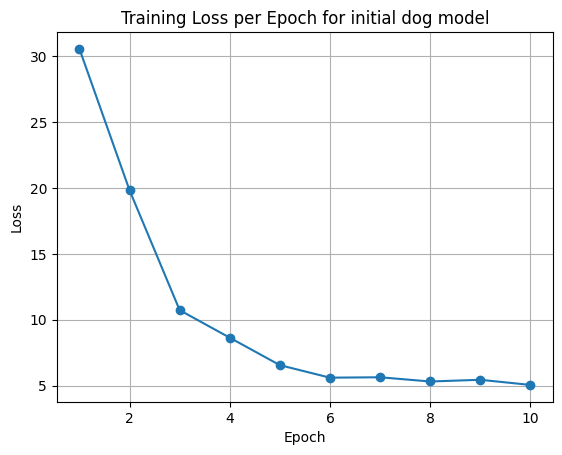

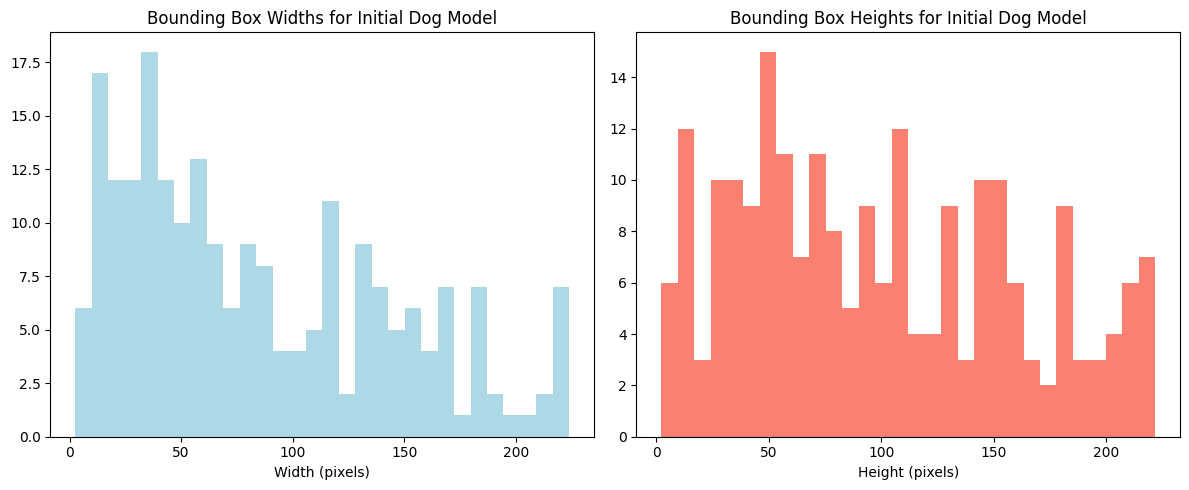

In [64]:
losses_per_dog_epoch = [30.54, 19.82, 10.73, 8.64, 6.56, 5.61, 5.64, 5.32, 5.45, 5.06] #Reconstructed from old readouts, actual loss data was lost, this was manually typed from old saved notebook
graph_losses_per_epoch(losses_per_dog_epoch, "initial dog model")
show_bounding_box_plot(val_dataset, 'Initial Dog Model')

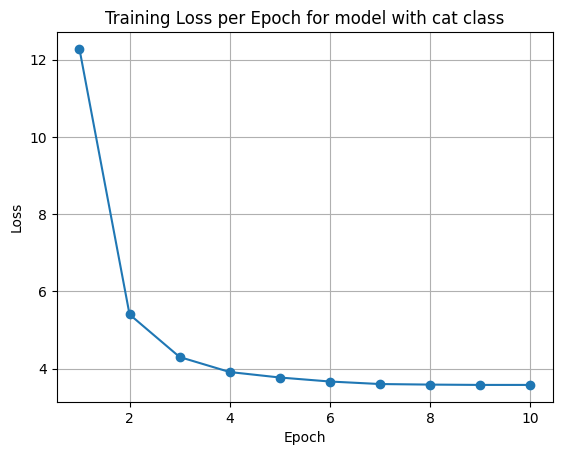

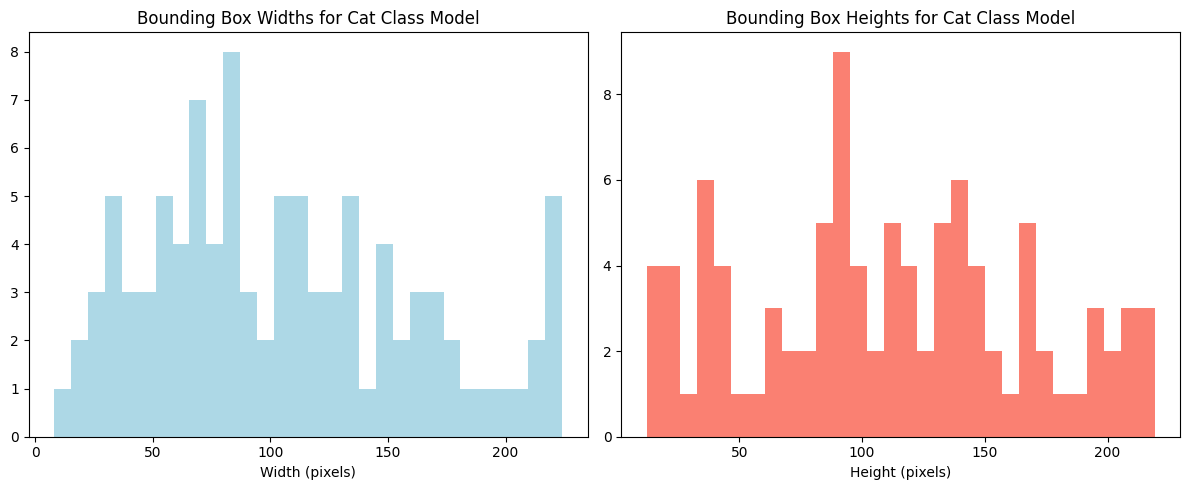

In [66]:
losses_per_cat_epoch = [12.2784, 5.4044, 4.3015, 3.9132, 3.7713, 3.6676, 3.6024, 3.5879, 3.5795, 3.5795] #Pulled from models and stored here
graph_losses_per_epoch(losses_per_cat_epoch, "model with cat class")
show_bounding_box_plot(new_cat_train_dataset, "Cat Class Model")

In [84]:
def select_higher_scores(dict1, dict2):
    result = {'scores': [], 'labels': [], 'masks': [], 'boxes': []}

    len1 = len(dict1['scores'])
    len2 = len(dict2['scores'])

    if len1 == 0 and len2 == 0:
        return result  # both empty

    elif len1 == 0:
        return dict2

    elif len2 == 0:
        return dict1

    else:
        for i in range(min(len1, len2)):
            if dict1['scores'][i] >= dict2['scores'][i]:
                result['scores'].append(dict1['scores'][i])
                result['labels'].append(dict1['labels'][i])
                result['masks'].append(dict1['masks'][i])
                result['boxes'].append(dict1['boxes'][i])
            else:
                result['scores'].append(dict2['scores'][i])
                result['labels'].append(dict2['labels'][i])
                result['masks'].append(dict2['masks'][i])
                result['boxes'].append(dict2['boxes'][i])

        return result


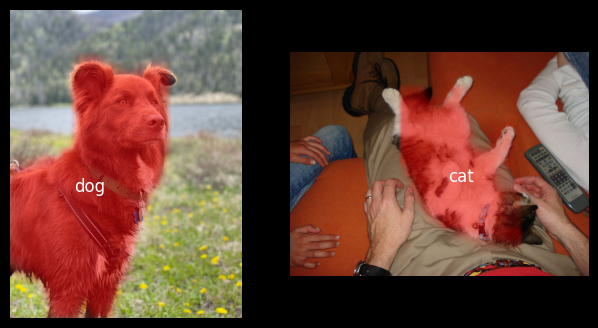

In [85]:
loaded_cat_model = get_instance_segmentation_model(categories=new_categories)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
loaded_cat_model.to(device)
checkpoint = torch.load('./../models/masrk_rcnn_epoch_10_CatClassTraining.pth', map_location=device)
loaded_cat_model.load_state_dict(checkpoint['model_state'])

cat_dog_label_map = new_cat_train_dataset.create_class_to_label_dict()


new_dog_image = './../theo.jpg' #Local image of a friends dog
new_cat_image = './../datasets/train/000000000443.jpg' #image from the train set of a cat
test_image_tensors_list = []
test_image_predictions_list = []

test_image_tensor, test_image_prediction1 = evaluate_maskrcnn_with_image(loaded_cat_model, new_dog_image, threshold=0.7)
test_image_tensor, test_image_prediction2 = evaluate_maskrcnn_with_image(loaded_model, new_dog_image, threshold=0.7)

test_image_prediction = select_higher_scores(test_image_prediction2, test_image_prediction1)

test_image_tensors_list.append(test_image_tensor)
test_image_predictions_list.append(test_image_prediction)

test_image_tensor, test_image_prediction = evaluate_maskrcnn_with_image(loaded_cat_model, new_cat_image, threshold=0.65)
test_image_tensors_list.append(test_image_tensor)
test_image_predictions_list.append(test_image_prediction)


visualize(test_image_tensors_list, test_image_predictions_list, cat_dog_label_map, enable_mask=True)

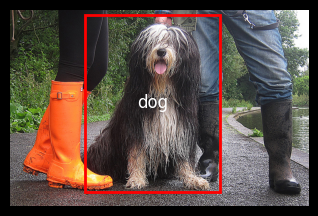

In [ ]:

directory = './../datasets/train'
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
if files:
    random_image = os.path.join(directory, random.choice(files))

test_image_tensor, test_image_prediction1 = evaluate_maskrcnn_with_image(loaded_cat_model, random_image, threshold=0.7)
test_image_tensor, test_image_prediction2 = evaluate_maskrcnn_with_image(loaded_model, random_image, threshold=0.7)

print(f"cat trained model score: {test_image_prediction1['scores']}")
print(f"dog trained model score: {test_image_prediction2['scores']}")

test_image_prediction = select_higher_scores(test_image_prediction2, test_image_prediction1)

visualize([test_image_tensor], [test_image_prediction], cat_dog_label_map, enable_box=True)